In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from tqdm import tqdm
import pickle
from classy import Class
from train_pybird_emulators.emu_utils import integrated_model
from train_pybird_emulators.emu_utils import emu_utils
from cosmic_toolbox import logger
from train_pybird_emulators.emu_utils.k_arrays import k_emu, k_pybird
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
# Assume x_train and y_train are your dataset

2024-10-16 06:59:42.411571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 06:59:42.428409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 06:59:42.433563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 06:59:42.446434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 06:59:44.252646: W tensorflow/compiler/tf2

loading loop matrices!


/scratch/tmp.11410586.areeves/ipykernel_18467/123915883.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
piece_name = "Ploopl"
model_name = "test_ploopl"
ntrain=200000
mono=True
quad_hex=False
mask_high_k=False
quad_alone=False
hex_alone=False
k_array_length = 77
training_data_file = "/cluster/scratch/areeves/pybird_training_data_pybird_gc/total_data.h5"

In [3]:
cov = emu_utils.get_default_cov()
print("cov shape", cov.shape)
flattened_rescale_factor = np.diag(cov)

cov shape (231, 231)


In [4]:
x_train, y_train = emu_utils.get_training_data_from_hdf5(
    training_data_file,
    piece_name,
    ntrain,
    mono,
    quad_hex,
    quad_alone,
    hex_alone,
    mask_high_k
)

24-10-16 06:59:55 train_pybi INF   total number of available training points: 2394400 
24-10-16 06:59:55 train_pybi INF   Available keys in the file: <KeysViewHDF5 ['IRPs11', 'IRPsct', 'IRPsloop', 'P11l', 'Pctl', 'Ploopl', 'params']> 
24-10-16 07:00:03 train_pybi INF   Using monopole data for Ploopl 
where are zeros?
(array([   0,   77,  154,  231,  308,  385,  462,  539,  616,  693,  770,
        847,  924, 1001, 1078, 1155, 1232, 1309, 1386, 1463, 1540, 1617,
       1694, 1771, 1848, 1925, 2002, 2079, 2156, 2233, 2310, 2387, 2464,
       2541, 2618, 2695, 2772, 2849, 2926, 3003, 3080, 3157, 3234, 3311,
       3388, 3465, 3542, 3619, 3696, 3773, 3850, 3927, 4004, 4081, 4158,
       4235, 4312, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4466,
       4467, 4468, 4469, 4470, 4471, 4472, 4473, 4543, 4620, 4697, 4774,
       4775, 4776, 4777, 4778, 4779, 4780, 4781, 4851, 4928, 4929, 4930,
       4931, 4932, 4933, 4934, 4935, 5005, 5006, 5007, 5008, 5009, 5010,
       5011, 5012, 5082

In [5]:
# print(f"filtering out bad indices for piece {piece_name}")

condition_1 = np.any(x_train[:, :-2] > 0, axis=1)
condition_2 = x_train[:, -1] < 0
condition_3 = x_train[:, -2] < 0
bad_inds = np.where(condition_1 | condition_2 | condition_3)[0]

# # bad_inds = np.where(condition_1 | condition_2 | condition_3 | condition_4)[0]

# #ensure that the gradients in the first 10 knots are not consecutively negative 
# # New condition: Two consecutive negative gradients in the first 10 positions
# # Compute gradients in the first 10 positions
gradients_first_5 = np.diff(x_train[:, :6], axis=1)  # Shape: (num_samples, 10)

# # # Identify negative gradients
negative_gradients = gradients_first_5 < 0  # Shape: (num_samples, 10)
condition_4 = np.any(negative_gradients, axis=1)


bad_inds = np.where(condition_1 | condition_2 | condition_3 | condition_4)[0]


# if piece_name.startswith("I"):
#     print("training IR piece... going to filter out large gradients")
    # Calculate the absolute gradients along each row
gradients = np.abs(np.diff(y_train, axis=1))

gradient_threshold = np.quantile(
    gradients, 0.95
)  # top 15% of gradients

# spikes typically happen around high k
spike_positions = np.arange(
    k_emu.shape[0] - 1, gradients.shape[1], k_emu.shape[0]
)  # Adjust for 0-index and diff output size

# Condition to identify rows with gradient spikes at specific positions
condition_5= np.any(
    gradients[:, spike_positions] > gradient_threshold, axis=1
)


bad_inds = np.where(
    condition_1 | condition_2 | condition_3 
)[0]


    

print(f"removing {len(bad_inds)} bad indices")
x_train = np.delete(x_train, bad_inds, axis=0)
y_train = np.delete(y_train, bad_inds, axis=0)

removing 2624 bad indices


In [6]:
# Are there places where all the columns in the data are zero?
zero_columns = np.where(np.sum(np.abs(y_train), axis=0) == 0)[0]

if zero_columns is not None and zero_columns.shape[0] > 0:
    # LOGGER.info(f"removing zero columns for piece {args.piece_name}")
    # remove and save zero columns indices
    np.save(f"zero_coumns_{piece_name}", zero_columns)
    y_train = np.delete(y_train, zero_columns, axis=1)

In [7]:
# Step 1: Scale the input data
input_scaler = StandardScaler().fit(x_train)
x_train_scaled = input_scaler.transform(x_train)
output_scaler = StandardScaler().fit(y_train)

In [34]:
output_scaler.mean_.shape 

(2660,)

In [35]:
y_train.shape 

(197376, 2660)

In [8]:
# Step 2: Define the autoencoder
input_dim = x_train_scaled.shape[1]
encoding_dim = 64  # Adjust as needed

input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')

# Step 3: Train the autoencoder
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

history = autoencoder.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

2024-10-16 07:00:23.291724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22996 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/100


I0000 00:00:1729054825.413066   18605 service.cc:146] XLA service 0x14a0f800d060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729054825.413107   18605 service.cc:154]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2024-10-16 07:00:25.448546: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 07:00:25.601282: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 93/617 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3457

I0000 00:00:1729054826.570044   18605 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0977 - val_loss: 0.0033
Epoch 2/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 3/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 9.5718e-04
Epoch 4/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010 - val_loss: 7.6630e-04
Epoch 5/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.2814e-04 - val_loss: 8.9090e-04
Epoch 6/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4250e-04 - val_loss: 7.1264e-04
Epoch 7/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3099e-04 - val_loss: 7.4169e-04
Epoch 8/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9827e-04 - val_loss: 3.3700e-04
Epoch 9/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4825e-04 - val_loss: 0.0013
Epoch 10/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0999e-04 - val_loss: 3.3437e-04
Epoch 11/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6491e-04 - val_loss: 4.82

6168/6168 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Mean Reconstruction Error: 0.0002


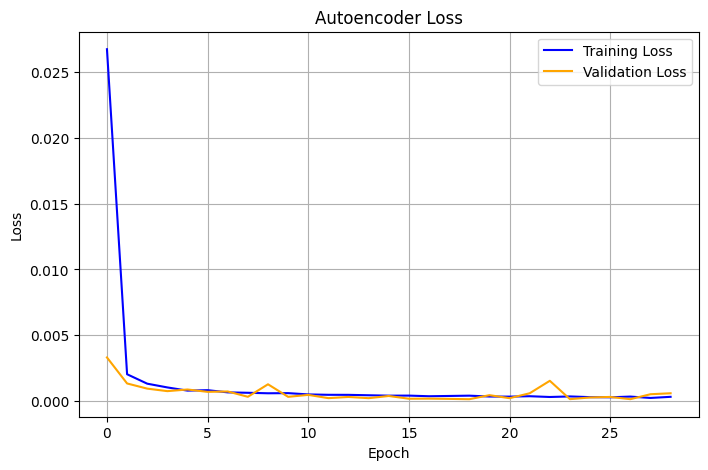

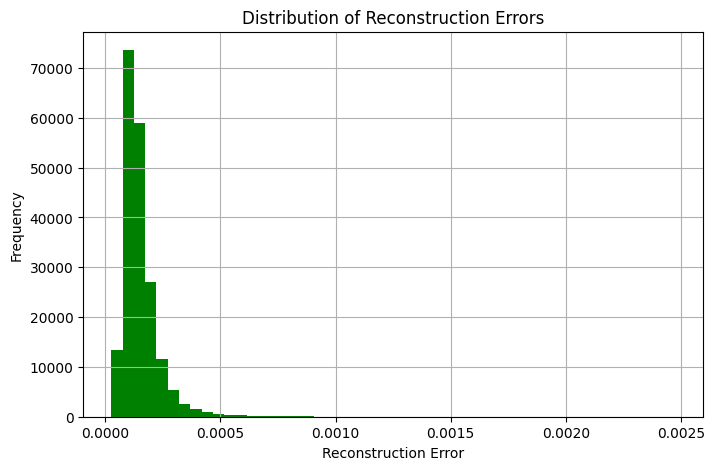

6168/6168 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [36]:
# Step 4: Evaluate the autoencoder
reconstructed_data = autoencoder.predict(x_train_scaled)
reconstruction_errors = np.mean(np.square(x_train_scaled - reconstructed_data), axis=1)
mean_reconstruction_error = np.mean(reconstruction_errors)
print(f"Mean Reconstruction Error: {mean_reconstruction_error:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(reconstruction_errors, bins=50, color='green')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step 5: Integrate with emulator
x_train_encoded = encoder.predict(x_train_scaled)
x_train_enc, x_val_enc, y_train_enc, y_val = train_test_split(
    x_train_encoded, y_train, test_size=0.2, random_state=42
)

# Update input_dim for the emulator
encoded_input_dim = x_train_encoded.shape[1]

In [37]:
y_val.shape 

(39476, 2660)

In [10]:


# Create the emulator model with the new input dimension
keras_model = integrated_model.create_model(
    input_dim=encoded_input_dim,
    hidden_layers=[128,128],
    output_dim=y_train.shape[1],
)

# Initialize the IntegratedModel without input scaling
model = integrated_model.IntegratedModel(
    keras_model,
    input_scaler=None,  # Data is already scaled and encoded
    output_scaler=output_scaler,  # If you have an output scaler
    offset=None,
    log_preprocess=False,
    temp_file=f"saved_models/{model_name}_temp",
    pca=None,
    pca_scaler=None,
    zero_columns=zero_columns,
    rescaling_factor=1.,
)

# Train the emulator using the encoded input data
model.train(
    x_train_enc,
    y_train_enc,
    epochs=600,
    batch_size=4096,
    validation_data=(x_val_enc, y_val)
)


Training with learning rate: 0.001


100%|██████████| 600/600 [07:06<00:00,  1.45epoch/s, train_loss=6.3173e-10, val_loss=4.6648e-10]

Restoring model weights from the end of the best epoch: 597.


100%|██████████| 600/600 [07:06<00:00,  1.41epoch/s, train_loss=6.3173e-10, val_loss=4.6648e-10]



Training with learning rate: 0.0005


100%|██████████| 600/600 [07:02<00:00,  1.46epoch/s, train_loss=2.3654e-10, val_loss=2.3713e-10]

Restoring model weights from the end of the best epoch: 600.


100%|██████████| 600/600 [07:02<00:00,  1.42epoch/s, train_loss=2.3654e-10, val_loss=2.3713e-10]



Training with learning rate: 0.0001


100%|██████████| 600/600 [07:01<00:00,  1.45epoch/s, train_loss=2.1328e-10, val_loss=2.1365e-10]

Restoring model weights from the end of the best epoch: 600.


100%|██████████| 600/600 [07:01<00:00,  1.42epoch/s, train_loss=2.1328e-10, val_loss=2.1365e-10]



Training with learning rate: 5e-05


100%|██████████| 600/600 [07:02<00:00,  1.45epoch/s, train_loss=2.0378e-10, val_loss=2.0413e-10]

Restoring model weights from the end of the best epoch: 600.


100%|██████████| 600/600 [07:02<00:00,  1.42epoch/s, train_loss=2.0378e-10, val_loss=2.0413e-10]


In [29]:
model.scaler_mean_in = 0
model.scaler_scale_in = 1
model.scaler_scale_out = output_scaler.scale_
model.scaler_mean_out = output_scaler.mean_
model.zero_columns = None

In [30]:
model.zero_columns

In [31]:
y_val.shape 

num_columns = y_val.shape[1]
all_columns = np.arange(num_columns)
mask = np.isin(all_columns, zero_columns, invert=True)


In [32]:
y_val[:, ~zero_columns].shape 

(39476, 35)

In [39]:
# Step 6: Evaluate the emulator
y_pred = model.predict(x_val_enc)

mse = mean_squared_error(y_val[:], y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")

# plt.figure(figsize=(8, 5))
# plt.scatter(y_val, y_pred, alpha=0.5)
# plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
# plt.title('Predicted vs. True Values')
# plt.xlabel('True Values')
# plt.ylabel('Predicted Values')
# plt.grid(True)
# plt.show()

Validation MSE: 0.0000
Validation RMSE: 0.0000
Validation MAE: 0.0000


KeyboardInterrupt: 

In [ ]:
predicted_testing_spectra = y_pred
testing_spectra = y_val

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,20))
for j in range(5):
    for i in range(5):
        pred = predicted_testing_spectra[i+j*3]
        true = testing_spectra[i+j*3]
        ell_range = np.arange(true.shape[0])
        ax[j, i].plot(ell_range, true, 'blue', label = 'Original')
        ax[j, i].plot(ell_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
        ax[j, i].set_xlabel('$\ell$', fontsize='x-large')
        ax[j, i].set_ylabel('$\\frac{[\ell(\ell+1)]^2}{2 \pi} C_\ell$', fontsize='x-large')
        ax[j, i].legend(fontsize=15)